# Crack 
> Crack 여부를 판단하는 모델을 만들어보자.
- toc: true
- branch: master
- badges: false
- comments: true
- author: dinonene
- categories: [python]

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, Adagrad
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf

import cv2
import os
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [7]:
print(keras.__version__)
print(cv2.__version__)
print(sns.__version__)
print(np.__version__)

2.10.0
4.6.0
0.12.0
1.23.4


In [8]:
os.getcwd() # 현재 작업 폴더

'C:\\Users\\hanka\\Desktop\\dino\\BP2022\\_notebooks'

In [9]:
# 폴더명
labels = ['Negative_500', 'Positive_500']
img_size = 120

# 어디 폴더의 Nagative, Postive를 불러오겠다.

def read_images(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                
                # 이미지 변경
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
                
    return np.array(data)

Dataset = read_images('./data/Surface_Crack_Detection_small')

In [10]:
print( Dataset.shape )
print( Dataset[0][0], Dataset[0][1]) # 피처와 Target

(1000, 2)
[[172 161 149 ... 183 182 184]
 [174 166 147 ... 176 175 177]
 [176 171 170 ... 180 176 176]
 ...
 [163 166 170 ... 175 175 173]
 [158 155 164 ... 172 173 171]
 [161 153 154 ... 170 172 170]] 0


In [11]:
# 폴더 내의 파일 수
data_dir = './data/Surface_Crack_Detection_small'
path_negative = os.path.join(data_dir, "Negative_500")
path_positive = os.path.join(data_dir, "Positive_500")

# 파일 및 폴더 내용 확인
print( len(os.listdir(path_negative) ))
print( len(os.listdir(path_positive) ))

num_n = len(os.listdir(path_negative) )
num_p = len(os.listdir(path_positive) )
num = [num_n, num_p]

500
500


### 파일 개수 확인

<BarContainer object of 2 artists>

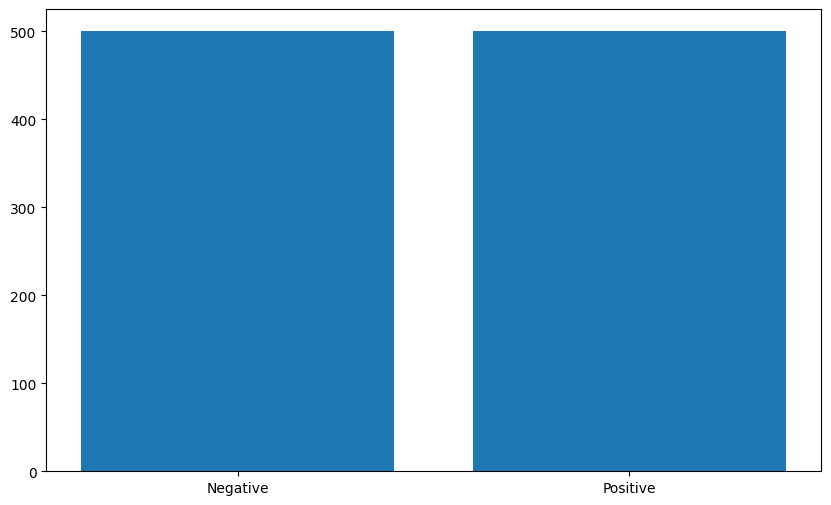

In [12]:
Im = ['Negative', 'Positive']
num = [num_n, num_p]

plt.figure(figsize=(10, 6))
x = np.arange(2)
plt.bar(Im, num)

In [13]:
Dataset[0]

array([array([[172, 161, 149, ..., 183, 182, 184],
              [174, 166, 147, ..., 176, 175, 177],
              [176, 171, 170, ..., 180, 176, 176],
              ...,
              [163, 166, 170, ..., 175, 175, 173],
              [158, 155, 164, ..., 172, 173, 171],
              [161, 153, 154, ..., 170, 172, 170]], dtype=uint8), 0],
      dtype=object)

In [15]:
print(Dataset.shape)

(1000, 2)


In [14]:
Dataset[0][0] # 픽셀 데이터

array([[172, 161, 149, ..., 183, 182, 184],
       [174, 166, 147, ..., 176, 175, 177],
       [176, 171, 170, ..., 180, 176, 176],
       ...,
       [163, 166, 170, ..., 175, 175, 173],
       [158, 155, 164, ..., 172, 173, 171],
       [161, 153, 154, ..., 170, 172, 170]], dtype=uint8)

### 데이터 전처리

In [18]:
x = []
y = []

for feature, label in Dataset:
    x.append(feature)
    y.append(label)


x = np.array(x).reshape(-1, img_size, img_size, 1)
x = x / 255
y = np.array(y)

print(x.shape, y.shape)

(1000, 120, 120, 1) (1000,)


(-0.5, 119.5, 119.5, -0.5)

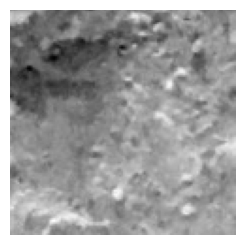

In [19]:
plt.subplot(1, 2, 1)
plt.imshow(x[300].reshape(img_size, img_size), cmap='gray')
plt.axis('off')

(-0.5, 119.5, 119.5, -0.5)

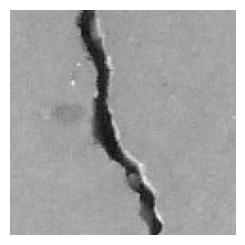

In [20]:
plt.subplot(1, 2, 2)
plt.imshow(x[500].reshape(img_size, img_size), cmap='gray')
plt.axis('off')

In [21]:
model = Sequential()
model.add(Conv2D(64, 3,padding="same", activation="relu", input_shape = x.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0

In [22]:
start = time.time()

opt = Adam(lr=1e-5)
model.compile(loss="binary_crossentropy", 
              optimizer=opt, metrics=["accuracy"]) 

history = model.fit(x, y, epochs = 15, 
                    batch_size = 128, validation_split = 0.25, verbose=1)

print("소요시간", time.time() - start )

Epoch 1/15
6/6 [==============================] - 11s 2s/step - loss: 0.6236 - accuracy: 0.6627 - val_loss: 0.7916 - val_accuracy: 0.0000e+00
Epoch 2/15
6/6 [==============================] - 10s 2s/step - loss: 0.5544 - accuracy: 0.7147 - val_loss: 0.8501 - val_accuracy: 0.0000e+00
Epoch 3/15
6/6 [==============================] - 10s 2s/step - loss: 0.5201 - accuracy: 0.7573 - val_loss: 0.8742 - val_accuracy: 0.0000e+00
Epoch 4/15
6/6 [==============================] - 11s 2s/step - loss: 0.4800 - accuracy: 0.7827 - val_loss: 0.8732 - val_accuracy: 0.0000e+00
Epoch 5/15
6/6 [==============================] - 11s 2s/step - loss: 0.4774 - accuracy: 0.7960 - val_loss: 0.8605 - val_accuracy: 0.0000e+00
Epoch 6/15
6/6 [==============================] - 11s 2s/step - loss: 0.4546 - accuracy: 0.8027 - val_loss: 0.8374 - val_accuracy: 0.0000e+00
Epoch 7/15
6/6 [==============================] - 10s 2s/step - loss: 0.4381 - accuracy: 0.8173 - val_loss: 0.8102 - val_accuracy: 0.0000e+00
Epoch 

Text(0.5, 1.0, 'Loss of the Model')

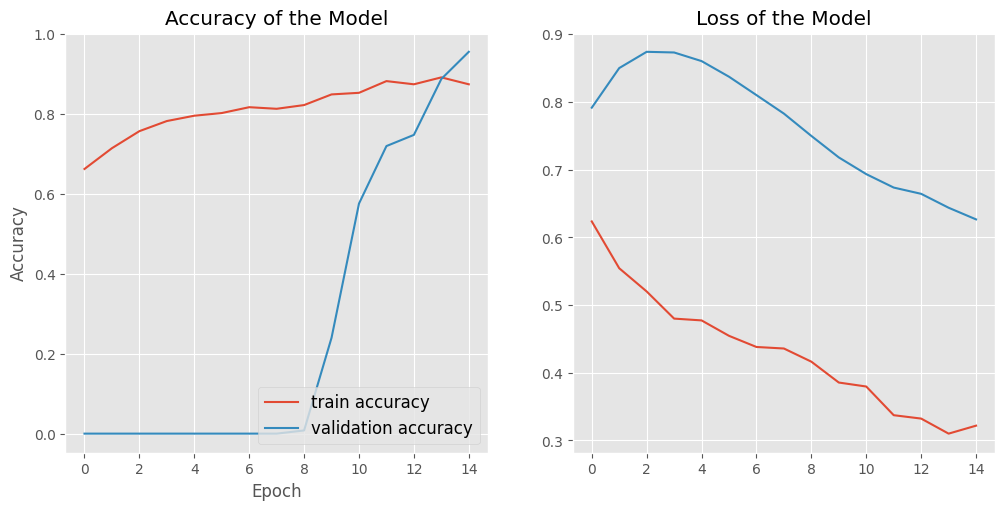

In [23]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')

plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], 
                     loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the Model')

- 한 에폭 당 6번밖에 학습을 못하니까 8에폭까지 성능변화가 없다가 그 이후에 올라가는 것을 볼 수 있다.

### 시도 1. barch size를 줄여서 한 에폭 당 학습횟수를 늘린다.

In [25]:
start = time.time()

opt = Adam(lr=1e-5)
model.compile(loss="binary_crossentropy", 
              optimizer=opt, metrics=["accuracy"]) 

history = model.fit(x, y, epochs = 15, 
                    batch_size = 16, validation_split = 0.25, verbose=1)

print("소요시간", time.time() - start )

Epoch 1/15
47/47 [==============================] - 13s 256ms/step - loss: 0.2841 - accuracy: 0.8987 - val_loss: 0.5707 - val_accuracy: 0.9680
Epoch 2/15
47/47 [==============================] - 13s 279ms/step - loss: 0.2494 - accuracy: 0.9227 - val_loss: 0.5101 - val_accuracy: 0.9760
Epoch 3/15
47/47 [==============================] - 13s 273ms/step - loss: 0.2229 - accuracy: 0.9387 - val_loss: 0.4406 - val_accuracy: 0.9880
Epoch 4/15
47/47 [==============================] - 12s 264ms/step - loss: 0.1932 - accuracy: 0.9427 - val_loss: 0.3940 - val_accuracy: 0.9680
Epoch 5/15
47/47 [==============================] - 12s 260ms/step - loss: 0.1846 - accuracy: 0.9480 - val_loss: 0.2834 - val_accuracy: 0.9920
Epoch 6/15
47/47 [==============================] - 13s 269ms/step - loss: 0.1569 - accuracy: 0.9573 - val_loss: 0.2352 - val_accuracy: 0.9840
Epoch 7/15
47/47 [==============================] - 12s 261ms/step - loss: 0.1490 - accuracy: 0.9600 - val_loss: 0.1286 - val_accuracy: 0.9960

Text(0.5, 1.0, 'Loss of the Model')

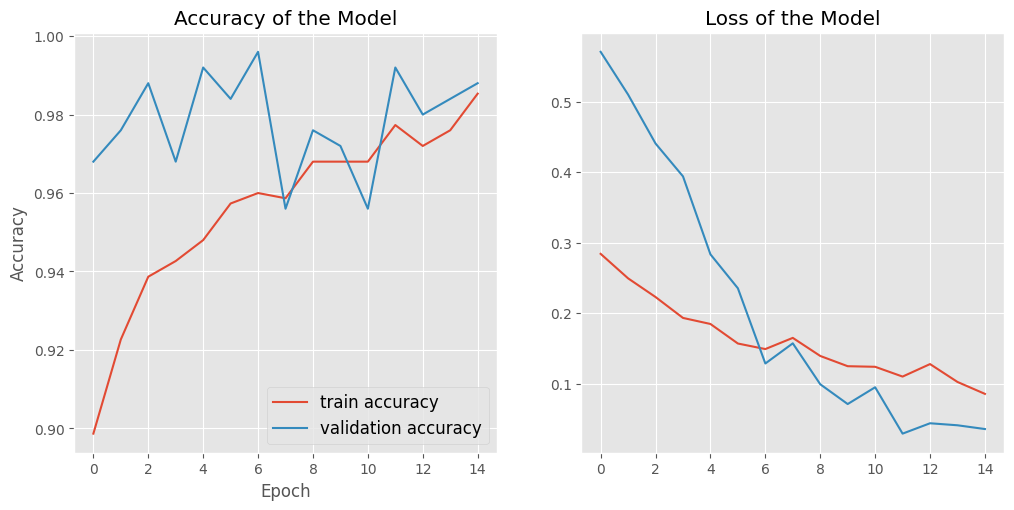

In [26]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')

plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], 
                     loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the Model')

### 시도 2. 에폭을 늘린다.

In [ ]:
start = time.time()

opt = Adam(lr=1e-5)
model.compile(loss="binary_crossentropy", 
              optimizer=opt, metrics=["accuracy"]) 

history = model.fit(x, y, epochs = 30, 
                    batch_size = 128, validation_split = 0.25, verbose=1)

print("소요시간", time.time() - start )

Epoch 1/30
4/6 [===================>..........] - ETA: 2s - loss: 0.0676 - accuracy: 0.9785

In [ ]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')

plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], 
                     loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the Model')